In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
MINST_path = '/content/drive/MyDrive/archive/'

In [ ]:
!ls -l "/content/drive/MyDrive/archive/"


total 53680
drwx------ 2 root root     4096 Apr 10 20:38 t10k-images-idx3-ubyte
-rw------- 1 root root  7840016 Oct 17  2019 t10k-images.idx3-ubyte
drwx------ 2 root root     4096 Apr 10 20:38 t10k-labels-idx1-ubyte
-rw------- 1 root root    10008 Oct 17  2019 t10k-labels.idx1-ubyte
drwx------ 2 root root     4096 Apr 10 20:38 train-images-idx3-ubyte
-rw------- 1 root root 47040016 Oct 17  2019 train-images.idx3-ubyte
drwx------ 2 root root     4096 Apr 10 20:38 train-labels-idx1-ubyte
-rw------- 1 root root    60008 Oct 17  2019 train-labels.idx1-ubyte


# Simple Experiment to prove Catastrophic Forgetting with just 2 Tasks

In [ ]:
import tensorflow as tf
import numpy as np
import struct

# Set your root path (Google Drive or local)
mnist_path = "/content/drive/MyDrive/archive/"  # Adjust this to your actual path

# Load MNIST images
def load_images_tf(filename):
    with open(filename, 'rb') as f:
        _, num_images, rows, cols = struct.unpack(">IIII", f.read(16))
        image_data = np.frombuffer(f.read(), dtype=np.uint8)
        images = image_data.reshape((num_images, rows, cols, 1))
        return tf.convert_to_tensor(images, dtype=tf.float32) / 255.0

# Load MNIST labels
def load_labels_tf(filename):
    with open(filename, 'rb') as f:
        _, num_labels = struct.unpack(">II", f.read(8))
        label_data = np.frombuffer(f.read(), dtype=np.uint8)
        return tf.convert_to_tensor(label_data, dtype=tf.int64)

# Load train/test data
X_train = load_images_tf(mnist_path + "train-images.idx3-ubyte")
y_train = load_labels_tf(mnist_path + "train-labels.idx1-ubyte")
X_test = load_images_tf(mnist_path + "t10k-images.idx3-ubyte")
y_test = load_labels_tf(mnist_path + "t10k-labels.idx1-ubyte")

# Print shapes
print('Training data shape: ', X_train.shape)
print('Training labels shape: ', y_train.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)


Training data shape:  (60000, 28, 28, 1)
Training labels shape:  (60000,)
Test data shape:  (10000, 28, 28, 1)
Test labels shape:  (10000,)


In [ ]:
# Split MNIST into two parts for catastrophic forgetting
X_train1 = X_train[y_train < 5]
y_train1 = y_train[y_train < 5]
X_train2 = X_train[y_train >= 5]
y_train2 = y_train[y_train >= 5]

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten

model = Sequential([
    Flatten(input_shape=(28, 28, 1)),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train on the first task (0-4 classes)
model.fit(X_train1, y_train1, epochs=10)

# Evaluate after Task 1
loss, accuracy = model.evaluate(X_train1, y_train1, verbose=0)
print(f"Accuracy on Task 1 after Task 1 training: {accuracy * 100:.2f}%")

# Train on the second task (5-9 classes)
model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train2, y_train2, epochs=10)

# Evaluate after Task 2
loss, accuracy = model.evaluate(X_train2, y_train2, verbose=0)
print(f"Accuracy on Task 2 after Task 2 training: {accuracy * 100:.2f}%")

# Evaluate on Task 1 after Task 2 training
loss, accuracy = model.evaluate(X_train1, y_train1, verbose=0)
print(f"Accuracy on Task 1 after Task 2 training: {accuracy * 100:.2f}%")


Epoch 1/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.8688 - loss: 0.5714
Epoch 2/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9626 - loss: 0.1332
Epoch 3/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9665 - loss: 0.1132
Epoch 4/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9676 - loss: 0.1062
Epoch 5/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9700 - loss: 0.1026
Epoch 6/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9737 - loss: 0.0905
Epoch 7/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9719 - loss: 0.0933
Epoch 8/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9758 - loss: 0.0825
Epoch 9/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - accuracy: 0.9747 - loss: 0.0857
Epoch 10/10
957/957 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.9768 - loss: 0.0787
Accuracy on Task 1 after Task 1 training: 97.77%
Epoch 1/10
919/919 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.8906 - loss: 0.4624
Epoc

Accuracy on Task 1 after Task 1 training: 99.15%
Accuracy on Task 2 after Task 2 training: 98.92%
Accuracy on Task 1 after Task 2 training: 4.53%


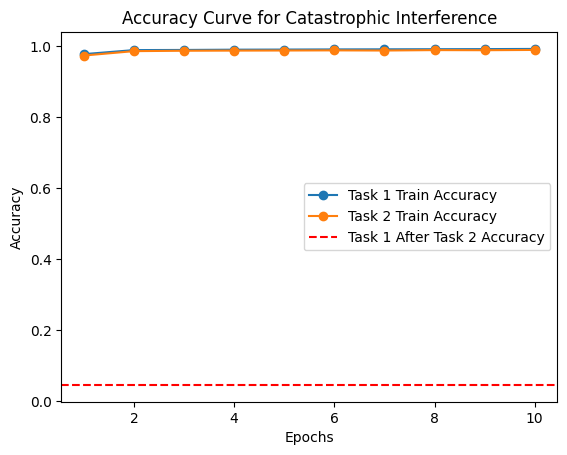

In [ ]:
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD

# Initialize lists to store accuracy per epoch for both tasks
task1_train_acc = []
task2_train_acc = []
task1_after_task2_acc = []

# Train on the first task (0-4 classes)
history_task1 = model.fit(X_train1, y_train1, epochs=10, verbose=0)

# Store Task 1 training accuracy
task1_train_acc = history_task1.history['accuracy']

# Evaluate after Task 1
loss, accuracy = model.evaluate(X_train1, y_train1, verbose=0)
print(f"Accuracy on Task 1 after Task 1 training: {accuracy * 100:.2f}%")

# Train on the second task (5-9 classes)
model.compile(optimizer=SGD(learning_rate=0.01), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history_task2 = model.fit(X_train2, y_train2, epochs=10, verbose=0)

# Store Task 2 training accuracy
task2_train_acc = history_task2.history['accuracy']

# Evaluate after Task 2
loss, accuracy = model.evaluate(X_train2, y_train2, verbose=0)
print(f"Accuracy on Task 2 after Task 2 training: {accuracy * 100:.2f}%")

# Evaluate on Task 1 after Task 2 training
loss, accuracy = model.evaluate(X_train1, y_train1, verbose=0)
print(f"Accuracy on Task 1 after Task 2 training: {accuracy * 100:.2f}%")

# Store accuracy on Task 1 after Task 2 training
task1_after_task2_acc = accuracy

# Plot the accuracy curve
epochs = np.arange(1, 11)
plt.plot(epochs, task1_train_acc, label='Task 1 Train Accuracy', marker='o')
plt.plot(epochs, task2_train_acc, label='Task 2 Train Accuracy', marker='o')
plt.axhline(y=task1_after_task2_acc, color='r', linestyle='--', label='Task 1 After Task 2 Accuracy')

plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Curve for Catastrophic Interference')
plt.legend()
plt.show()


# Basic Experiment to Understand Catastrophic Forgetting by using Permutation

100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.2MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.35MB/s]



=== Training on Task 1 ===
  Epoch 1/10, Loss: 0.6585
  Epoch 2/10, Loss: 0.3334
  Epoch 3/10, Loss: 0.2936
  Epoch 4/10, Loss: 0.2711
  Epoch 5/10, Loss: 0.2548
  Epoch 6/10, Loss: 0.2416
  Epoch 7/10, Loss: 0.2300
  Epoch 8/10, Loss: 0.2202
  Epoch 9/10, Loss: 0.2115
  Epoch 10/10, Loss: 0.2035
  Accuracy on Task 1: 93.92%

=== Training on Task 2 ===
  Epoch 1/10, Loss: 0.4641
  Epoch 2/10, Loss: 0.2808
  Epoch 3/10, Loss: 0.2476
  Epoch 4/10, Loss: 0.2273
  Epoch 5/10, Loss: 0.2125
  Epoch 6/10, Loss: 0.2017
  Epoch 7/10, Loss: 0.1928
  Epoch 8/10, Loss: 0.1856
  Epoch 9/10, Loss: 0.1794
  Epoch 10/10, Loss: 0.1743
  Accuracy on Task 1: 85.92%
  Accuracy on Task 2: 94.60%

=== Training on Task 3 ===
  Epoch 1/10, Loss: 0.4652
  Epoch 2/10, Loss: 0.2677
  Epoch 3/10, Loss: 0.2335
  Epoch 4/10, Loss: 0.2148
  Epoch 5/10, Loss: 0.2020
  Epoch 6/10, Loss: 0.1923
  Epoch 7/10, Loss: 0.1848
  Epoch 8/10, Loss: 0.1786
  Epoch 9/10, Loss: 0.1731
  Epoch 10/10, Loss: 0.1684
  Accuracy on Ta

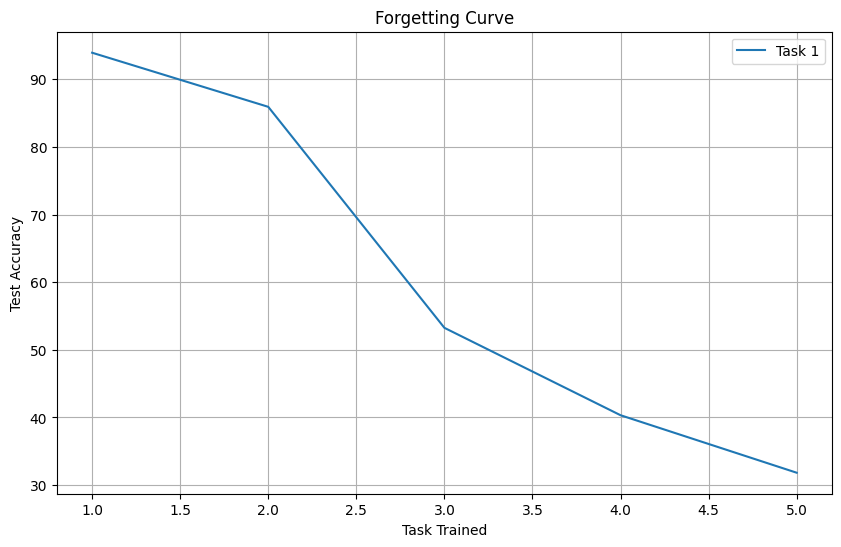

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt

device = 'cuda:3' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(0)
np.random.seed(0)

# Hyperparameters
N_TASKS = 5
num_epochs = 10
batch_size = 64
learning_rate = 0.01

class SimpleMLP(nn.Module):
    def __init__(self):
        super(SimpleMLP, self).__init__()
        self.net = nn.Sequential(
            nn.Flatten(),
            nn.Linear(28*28, 16),
            nn.ReLU(),
            nn.Linear(16, 10)
        )
    def forward(self, x):
        return self.net(x)

class PermutedMNIST(Dataset):
    def __init__(self, original_dataset, permutation):
        self.dataset = original_dataset
        self.permutation = permutation
    def __getitem__(self, index):
        img, label = self.dataset[index]
        img = img.view(-1)
        img = img[self.permutation]
        return img.view(1, 28, 28), label
    def __len__(self):
        return len(self.dataset)

# Load original MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])
base_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)
base_test = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform)

# Generate permutations for each task
permutations = [torch.randperm(28*28) for _ in range(N_TASKS)]

# Create datasets/loaders for each task
train_loaders = []
test_loaders = []

for perm in permutations:
    train_set = PermutedMNIST(base_train, perm)
    test_set = PermutedMNIST(base_test, perm)
    train_loaders.append(DataLoader(train_set, batch_size=batch_size, shuffle=True))
    test_loaders.append(DataLoader(test_set, batch_size=batch_size, shuffle=False))

def evaluate(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train_on_task(model, optimizer, criterion, loader, epochs):
    model.train()
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {total_loss/len(loader):.4f}")

# Initialize model, loss, optimizer
model = SimpleMLP().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate)

# Track accuracy after each task
acc_matrix = []

for task_id in range(N_TASKS):
    print(f"\n=== Training on Task {task_id + 1} ===")
    train_on_task(model, optimizer, criterion, train_loaders[task_id], num_epochs)

    task_accs = []
    for eval_id in range(task_id + 1):
        acc = evaluate(model, test_loaders[eval_id])
        print(f"  Accuracy on Task {eval_id + 1}: {acc:.2f}%")
        task_accs.append(acc)
    acc_matrix.append(task_accs)

# Plot forgetting
plt.figure(figsize=(10, 6))
for i, accs in enumerate(zip(*acc_matrix)):
    plt.plot(range(i + 1, N_TASKS + 1), accs, label=f"Task {i+1}")
plt.xlabel("Task Trained")
plt.ylabel("Test Accuracy")
plt.title("Forgetting Curve")
plt.legend()
plt.grid(True)
plt.show()


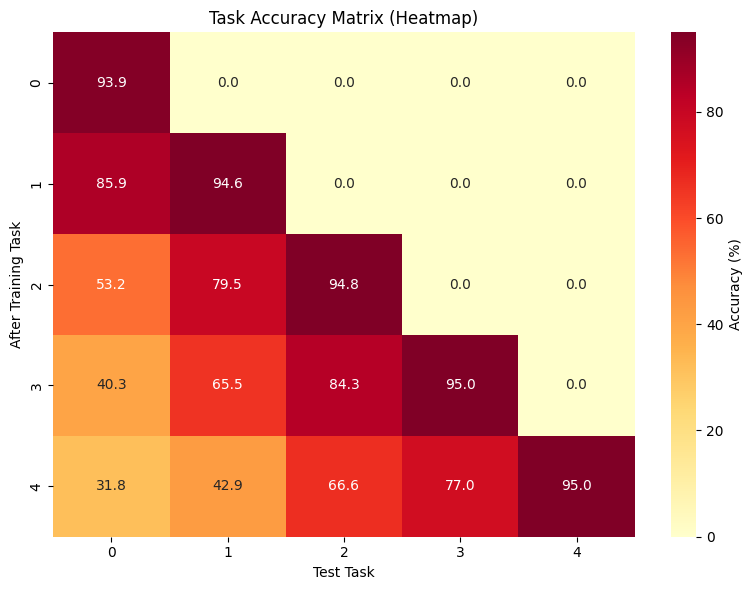

In [ ]:
import seaborn as sns

# Pad acc_matrix to square shape
acc_array = np.zeros((N_TASKS, N_TASKS))
for i in range(N_TASKS):
    acc_array[i, :len(acc_matrix[i])] = acc_matrix[i]

plt.figure(figsize=(8, 6))
sns.heatmap(acc_array, annot=True, fmt=".1f", cmap="YlOrRd", cbar_kws={'label': 'Accuracy (%)'})
plt.xlabel("Test Task")
plt.ylabel("After Training Task")
plt.title("Task Accuracy Matrix (Heatmap)")
plt.tight_layout()
plt.show()


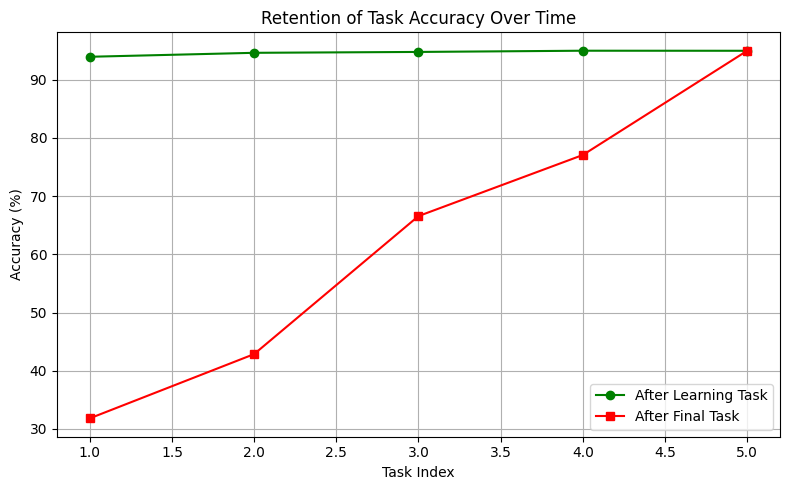

In [ ]:
# Accuracy on task immediately after learning vs. after final task
initial_acc = [acc_matrix[i][i] for i in range(N_TASKS)]
final_acc = [acc_matrix[-1][i] if i < len(acc_matrix[-1]) else 0 for i in range(N_TASKS)]

plt.figure(figsize=(8, 5))
x = np.arange(1, N_TASKS + 1)
plt.plot(x, initial_acc, marker='o', label="After Learning Task", color='green')
plt.plot(x, final_acc, marker='s', label="After Final Task", color='red')
plt.xlabel("Task Index")
plt.ylabel("Accuracy (%)")
plt.title("Retention of Task Accuracy Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



=== Training on Task 1 ===
  Epoch 1/10, Loss: 0.3265
  Epoch 2/10, Loss: 0.2197
  Epoch 3/10, Loss: 0.1981
  Epoch 4/10, Loss: 0.1856
  Epoch 5/10, Loss: 0.1763
  Epoch 6/10, Loss: 0.1690
  Epoch 7/10, Loss: 0.1631
  Epoch 8/10, Loss: 0.1583
  Epoch 9/10, Loss: 0.1545
  Epoch 10/10, Loss: 0.1501

=== Training on Task 2 ===
  Epoch 1/10, Loss: 0.2829
  Epoch 2/10, Loss: 0.2016
  Epoch 3/10, Loss: 0.1839
  Epoch 4/10, Loss: 0.1731
  Epoch 5/10, Loss: 0.1655
  Epoch 6/10, Loss: 0.1595
  Epoch 7/10, Loss: 0.1548
  Epoch 8/10, Loss: 0.1503
  Epoch 9/10, Loss: 0.1469
  Epoch 10/10, Loss: 0.1439

=== Training on Task 3 ===
  Epoch 1/10, Loss: 0.2843
  Epoch 2/10, Loss: 0.2061
  Epoch 3/10, Loss: 0.1881
  Epoch 4/10, Loss: 0.1782
  Epoch 5/10, Loss: 0.1701
  Epoch 6/10, Loss: 0.1644
  Epoch 7/10, Loss: 0.1597
  Epoch 8/10, Loss: 0.1559
  Epoch 9/10, Loss: 0.1522
  Epoch 10/10, Loss: 0.1495

=== Training on Task 4 ===
  Epoch 1/10, Loss: 0.2739
  Epoch 2/10, Loss: 0.2021
  Epoch 3/10, Loss: 0

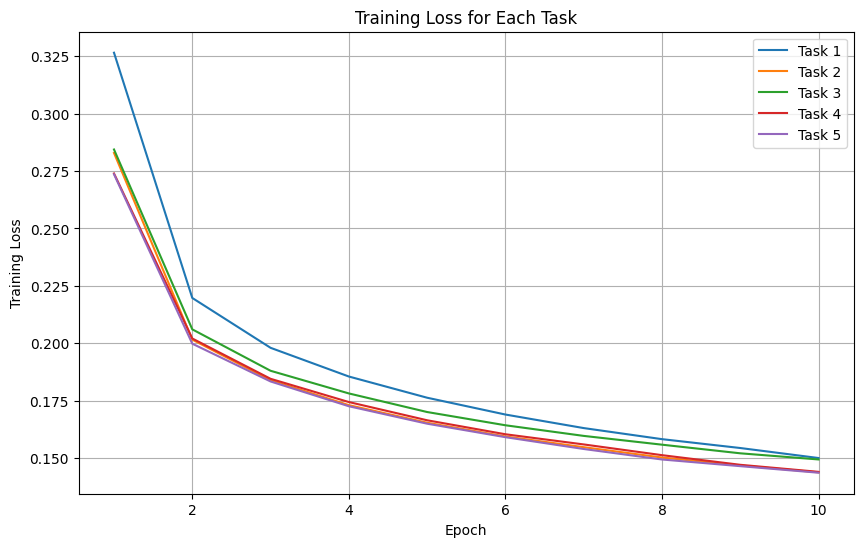

In [ ]:
def train_on_task_with_loss(model, optimizer, criterion, loader, epochs):
    model.train()
    epoch_losses = []
    for epoch in range(epochs):
        total_loss = 0.0
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        epoch_losses.append(total_loss / len(loader))
        print(f"  Epoch {epoch+1}/{epochs}, Loss: {epoch_losses[-1]:.4f}")
    return epoch_losses

# Training and plotting losses for each task
task_losses = []
for task_id in range(N_TASKS):
    print(f"\n=== Training on Task {task_id + 1} ===")
    task_losses.append(train_on_task_with_loss(model, optimizer, criterion, train_loaders[task_id], num_epochs))

# Plot training loss across tasks
plt.figure(figsize=(10, 6))
for i, losses in enumerate(task_losses):
    plt.plot(range(1, num_epochs + 1), losses, label=f"Task {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Training Loss")
plt.title("Training Loss for Each Task")
plt.legend()
plt.grid(True)
plt.show()



=== Training on Task 1 ===
  Epoch 1/1, Loss: 0.2552
  Epoch 1/1, Loss: 0.1851
  Epoch 1/1, Loss: 0.1706
  Epoch 1/1, Loss: 0.1611
  Epoch 1/1, Loss: 0.1547
  Epoch 1/1, Loss: 0.1493
  Epoch 1/1, Loss: 0.1449
  Epoch 1/1, Loss: 0.1412
  Epoch 1/1, Loss: 0.1379
  Epoch 1/1, Loss: 0.1350

=== Training on Task 2 ===
  Epoch 1/1, Loss: 0.2355
  Epoch 1/1, Loss: 0.1759
  Epoch 1/1, Loss: 0.1627
  Epoch 1/1, Loss: 0.1542
  Epoch 1/1, Loss: 0.1487
  Epoch 1/1, Loss: 0.1438
  Epoch 1/1, Loss: 0.1399
  Epoch 1/1, Loss: 0.1363
  Epoch 1/1, Loss: 0.1339
  Epoch 1/1, Loss: 0.1310

=== Training on Task 3 ===
  Epoch 1/1, Loss: 0.2509
  Epoch 1/1, Loss: 0.1888
  Epoch 1/1, Loss: 0.1734
  Epoch 1/1, Loss: 0.1645
  Epoch 1/1, Loss: 0.1583
  Epoch 1/1, Loss: 0.1536
  Epoch 1/1, Loss: 0.1494
  Epoch 1/1, Loss: 0.1460
  Epoch 1/1, Loss: 0.1428
  Epoch 1/1, Loss: 0.1401

=== Training on Task 4 ===
  Epoch 1/1, Loss: 0.2385
  Epoch 1/1, Loss: 0.1812
  Epoch 1/1, Loss: 0.1671
  Epoch 1/1, Loss: 0.1589
  Ep

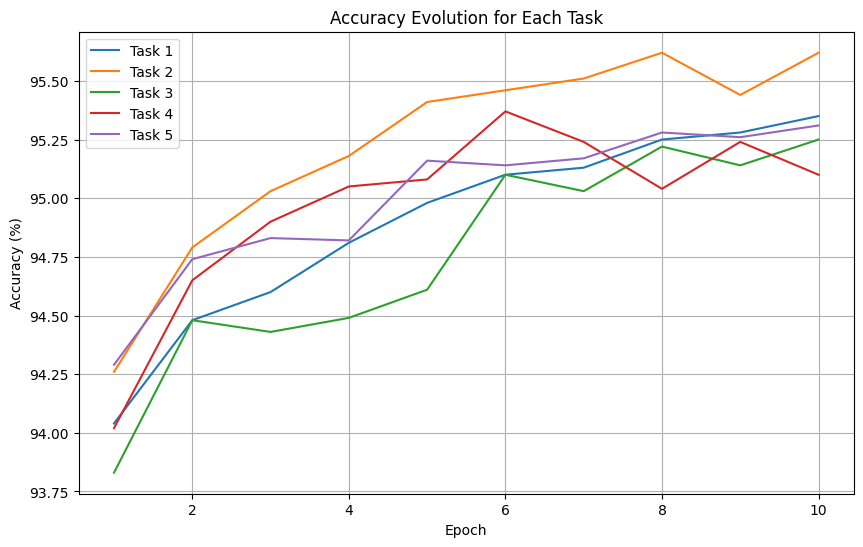

In [ ]:
def evaluate_epoch_wise(model, data_loader):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

epoch_accs = []
for task_id in range(N_TASKS):
    print(f"\n=== Training on Task {task_id + 1} ===")
    task_acc = []
    for epoch in range(num_epochs):
        train_on_task(model, optimizer, criterion, train_loaders[task_id], 1)
        acc = evaluate_epoch_wise(model, test_loaders[task_id])
        task_acc.append(acc)
    epoch_accs.append(task_acc)

# Plot accuracy after each epoch for each task
plt.figure(figsize=(10, 6))
for i, accs in enumerate(epoch_accs):
    plt.plot(range(1, num_epochs + 1), accs, label=f"Task {i + 1}")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Evolution for Each Task")
plt.legend()
plt.grid(True)
plt.show()


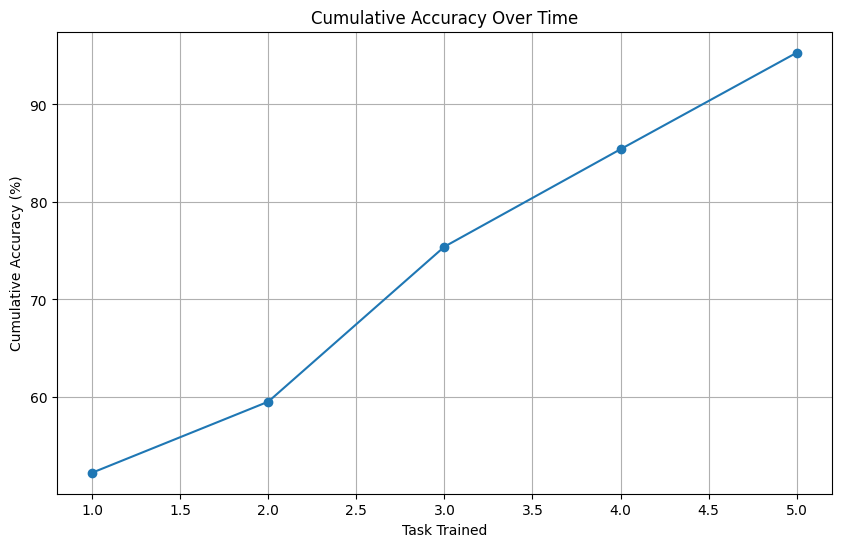

In [ ]:
cumulative_acc = []
for task_id in range(N_TASKS):
    model.eval()
    acc = evaluate(model, test_loaders[task_id])
    cumulative_acc.append(acc)

# Plot cumulative accuracy
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_TASKS + 1), cumulative_acc, marker='o', label="Cumulative Accuracy")
plt.xlabel("Task Trained")
plt.ylabel("Cumulative Accuracy (%)")
plt.title("Cumulative Accuracy Over Time")
plt.grid(True)
plt.show()


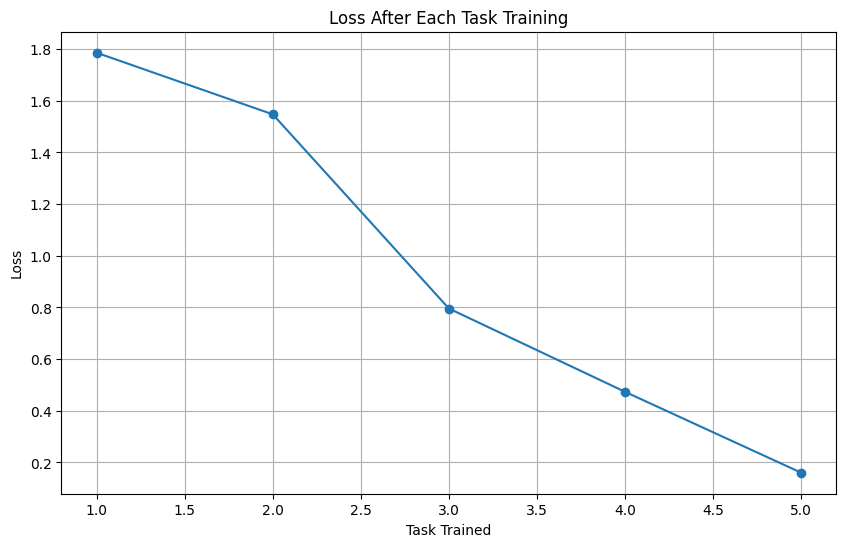

In [ ]:
cumulative_loss = []
for task_id in range(N_TASKS):
    model.eval()
    total_loss = 0.0
    with torch.no_grad():
        for images, labels in test_loaders[task_id]:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            total_loss += loss.item()
    cumulative_loss.append(total_loss / len(test_loaders[task_id]))

# Plot loss after each task
plt.figure(figsize=(10, 6))
plt.plot(range(1, N_TASKS + 1), cumulative_loss, marker='o', label="Task Loss")
plt.xlabel("Task Trained")
plt.ylabel("Loss")
plt.title("Loss After Each Task Training")
plt.grid(True)
plt.show()


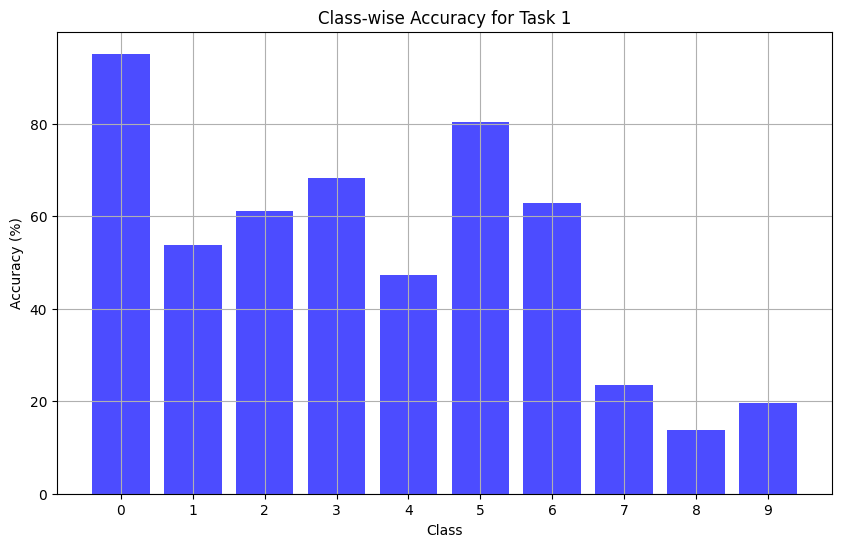

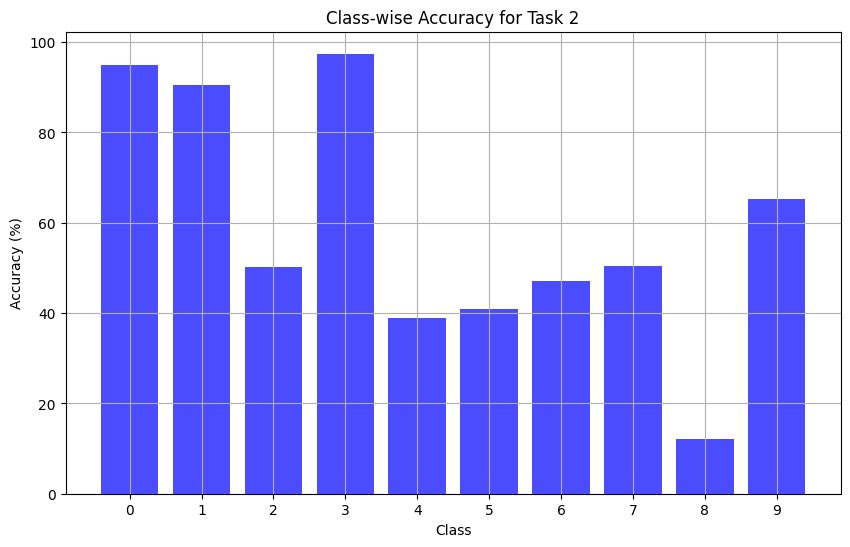

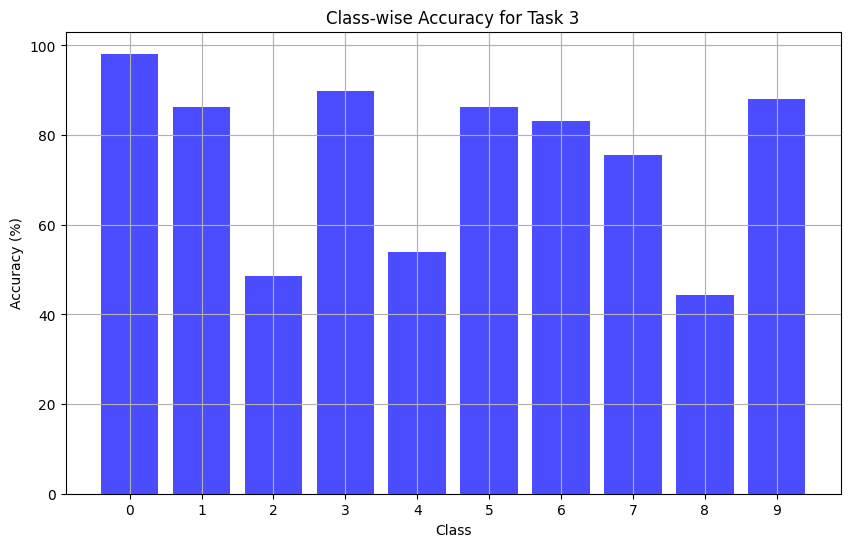

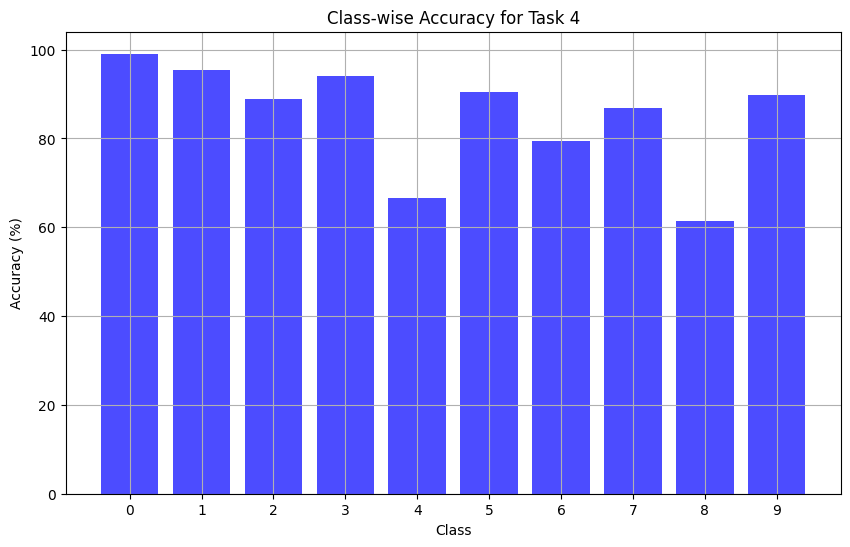

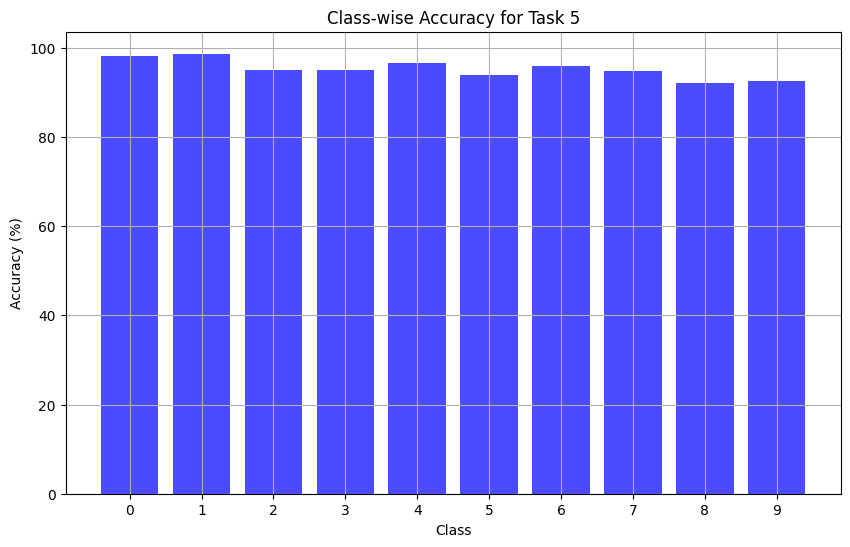

In [ ]:
def class_wise_accuracy(model, data_loader):
    model.eval()
    class_correct = [0] * 10
    class_total = [0] * 10
    with torch.no_grad():
        for images, labels in data_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(labels.size(0)):
                label = labels[i]
                class_correct[label] += (predicted[i] == label).item()
                class_total[label] += 1
    return [100 * correct / total for correct, total in zip(class_correct, class_total)]

class_accuracies = []
for task_id in range(N_TASKS):
    acc = class_wise_accuracy(model, test_loaders[task_id])
    class_accuracies.append(acc)

# Plot class-wise accuracy
for i, acc in enumerate(class_accuracies):
    plt.figure(figsize=(10, 6))
    plt.bar(range(10), acc, color='blue', alpha=0.7)
    plt.xlabel("Class")
    plt.ylabel("Accuracy (%)")
    plt.title(f"Class-wise Accuracy for Task {i + 1}")
    plt.xticks(range(10), [str(i) for i in range(10)])
    plt.grid(True)
    plt.show()


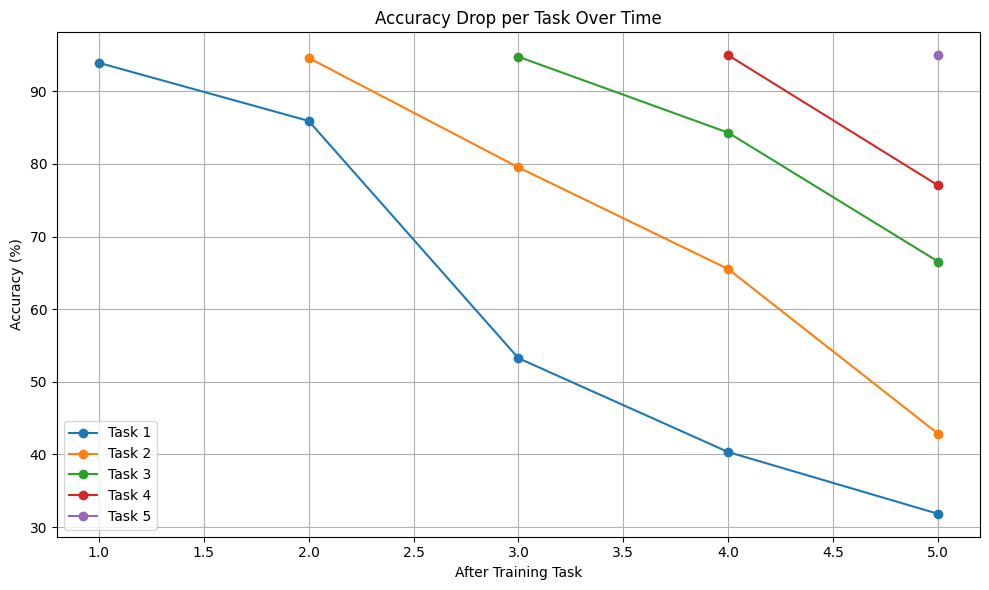

In [ ]:
plt.figure(figsize=(10, 6))
for task_idx in range(N_TASKS):
    task_accuracies = []
    for i in range(task_idx, N_TASKS):
        if task_idx <= i and task_idx < len(acc_matrix[i]):
            task_accuracies.append(acc_matrix[i][task_idx])
        else:
            task_accuracies.append(None)  # Not available
    x = np.arange(task_idx + 1, N_TASKS + 1)
    plt.plot(x, task_accuracies, marker='o', label=f"Task {task_idx + 1}")

plt.xlabel("After Training Task")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Drop per Task Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
